In [1]:
import os
import cv2
import json
import time
import joblib
import pandas as pd
import numpy as np

import imageio
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

import keras
from keras.callbacks import EarlyStopping
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

2023-06-23 21:44:21.567317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 21:44:21.900324: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-23 21:44:22.996248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bmarghescu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-23 21:44:22.996380: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugi

In [2]:
DATASET_DIR = "Datasets/EMO-IIT"
SPECTROGRAM_DIR = "Spectrograms/EMO-IIT/Log"
TF_RECORDS_DIR = "TFRecords/EMO-IIT"
TF_RECORDS_NAME = "EMO-IIT_log.tfrecords"
MODEL_DIR = "Models"
MODEL_NAME = "EMO-IIT_log.h5"
NUM_CLASSES = 8
SAMPLE_RATE = 16000
BATCH_SIZE = 32
EPOCHS = 13
RANDOM_SEED = 42

In [3]:
def create_dataframe_emodb():
    EMOTION_DICT_EMODB = {'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'fear', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'}
    if DATASET_DIR != "Datasets/EmoDB" and DATASET_DIR != "Datasets/Converted Datasets/EmoDB":
        raise Exception("DATASET_DIR must be set to 'Datasets/EmoDB' or 'Datasets/Converted Datasets/EmoDB' for EmoDB dataset")
    file_person, file_gender, file_emotion, file_path = [], [], [], []
    file_list = os.listdir(DATASET_DIR)
    for file in file_list:
        person = int(file[0:2])
        gender = 'male' if person in [3, 10, 11, 12, 15] else 'female'
        emotion = EMOTION_DICT_EMODB[file[5]]
        file_person.append(person)
        file_gender.append(gender)
        file_emotion.append(emotion)
        file_path.append(os.path.join(DATASET_DIR, file))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'path': file_path}
    emodb_df = pd.DataFrame(file_dict)
    return emodb_df

In [4]:
def create_dataframe_emoiit():
    if DATASET_DIR != "Datasets/EMO-IIT" and DATASET_DIR != "Datasets/Converted Datasets/EMO-IIT":
        raise Exception("DATASET_DIR must be set to 'Datasets/EMO-IIT' or 'Datasets/Converted Datasets/EMO-IIT' for EMO-IIT dataset")
    file_emotion, file_path = [], []
    emotion_dir_list = os.listdir(DATASET_DIR)
    for emotion_dir in emotion_dir_list:
        file_list = os.listdir(os.path.join(DATASET_DIR, emotion_dir))
        for file in file_list:
            if file.endswith('.wav'):
                file_emotion.append(emotion_dir)
                file_path.append(os.path.join(DATASET_DIR, emotion_dir, file))
    file_dict = {'emotion': file_emotion, 'path': file_path}
    emoiit_df = pd.DataFrame(file_dict)
    emoiit_df = pd.DataFrame(shuffle(emoiit_df, random_state=RANDOM_SEED), columns=emoiit_df.columns).reset_index(drop=True, inplace=False)
    return emoiit_df

In [5]:
def create_dataframe_ravdess():
    emotion_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    if DATASET_DIR != "Datasets/RAVDESS/audio_speech_actors_01-24" and DATASET_DIR != "Datasets/Converted Datasets/RAVDESS":
        raise Exception("DATASET_DIR must be set to 'Datasets/RAVDESS/audio_speech_actors_01-24' or 'Datasets/Converted Datasets/RAVDESS' for RAVDESS dataset")
    file_person, file_gender, file_emotion, file_intensity, file_path = [], [], [], [], []
    person_dir_list = os.listdir(DATASET_DIR)
    for person_dir in person_dir_list:
        if person_dir.startswith("Actor_"):
            person = int(person_dir.split("_")[1])
            file_list_person = os.listdir(os.path.join(DATASET_DIR, person_dir))
            for file in file_list_person:
                if file.endswith(".wav"):
                    file_person.append(person)
                    file_path.append(os.path.join(DATASET_DIR, person_dir, file))
                    file_gender.append("male" if person % 2 == 1 else "female")
                    file_emotion.append(emotion_list[int(file.split("-")[2]) - 1])
                    file_intensity.append(int(file.split("-")[3].split(".")[0]))
    file_dict = {'person': file_person, 'gender': file_gender, 'emotion': file_emotion, 'intensity': file_intensity, 'path': file_path}
    ravdess_df = pd.DataFrame(file_dict)
    ravdess_df = pd.DataFrame(shuffle(ravdess_df, random_state=RANDOM_SEED), columns=ravdess_df.columns).reset_index(drop=True, inplace=False)
    return ravdess_df

In [6]:
def preprocess_dataset(ser_df, dataset_type, ohe=None, fold=None):
    audio_block_list = []
    emotion_list = []
    for row in tqdm(ser_df.itertuples(), desc=f"Preprocessing audio files dataset - {dataset_type}", total=len(ser_df)):
        data, _ = librosa.load(row.path, sr=SAMPLE_RATE)
        if data.shape[0] < SAMPLE_RATE:
            data = np.pad(data, (0, SAMPLE_RATE - data.shape[0]), 'constant')
        frames = librosa.util.frame(data, frame_length=SAMPLE_RATE, hop_length=int(SAMPLE_RATE/100)).T
        for frame in frames:
            audio_block_list.append(frame)
            emotion_list.append(row.emotion)
    audio_block_list = np.array(audio_block_list)
    emotion_list = np.array(emotion_list)
    if ohe is None:
        ohe = OneHotEncoder(categories='auto', sparse=False)
        emotion_list = ohe.fit_transform(emotion_list[:, np.newaxis])
        ohe_path = os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", f"_fold_{fold + 1}_ohe.pkl")) if fold is not None else os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl"))
        joblib.dump(ohe, ohe_path)
    else:
        emotion_list = ohe.transform(emotion_list[:, np.newaxis])
    return audio_block_list, emotion_list

In [7]:
def create_spectrogram_log(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    Xdb = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(Xdb))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [8]:
def create_spectrogram_linear(data, sr):
    X = np.abs(librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=np.amin(X), vmax=np.amax(X))
    image = cmap(norm(X))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [9]:
def create_spectrogram_mel(data, sr):
    Xmel = np.abs(librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4)))
    X_mel_db = librosa.amplitude_to_db(Xmel, ref=np.max)
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(X_mel_db))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [10]:
def create_spectrogram_hpss(data, sr):
    X = librosa.stft(data, window=hamming(int(np.round(sr / 1000) * 32)), n_fft=int(np.round(sr / 1000) * 32), hop_length=int(np.round(sr / 1000) * 4))
    X_harmonic, X_percussive = librosa.decompose.hpss(X)
    X_db = librosa.amplitude_to_db(np.abs(X), ref=np.max)
    X_harmonic_db = librosa.amplitude_to_db(np.abs(X_harmonic), ref=np.max)
    X_percussive_db = librosa.amplitude_to_db(np.abs(X_percussive), ref=np.max)
    image = np.hstack((X_db, X_harmonic_db, X_percussive_db))
    cmap = plt.cm.jet
    norm = plt.Normalize(vmin=-90, vmax=-7)
    image = cmap(norm(image))
    image = image[:, :, :3]
    image = cv2.normalize(src=np.flip(image, axis=0), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)
    return image

In [11]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_png(value).numpy()])
    )


def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

In [12]:
def create_example_train(image, path, emotion_id):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [13]:
def create_example_test(image, path, emotion_id, sample_weight):
    feature = {
        "image": image_feature(image),
        "path": bytes_feature(path),
        "emotion_id": float_feature(emotion_id),
        "sample_weight": float_feature(sample_weight),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [14]:
def parse_tfrecord_train(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example


def parse_tfrecord_test(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "emotion_id": tf.io.FixedLenFeature([NUM_CLASSES], tf.float32),
        "sample_weight": tf.io.FixedLenFeature([1], tf.float32),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_png(example["image"], channels=3)
    return example

In [15]:
def create_spectrogram_dataset(audio_block_list, emotion_list, sr, create_spectrogram, sample_weight=None, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    if not os.path.exists(os.path.join(TF_RECORDS_DIR, dataset_type)):
        os.makedirs(os.path.join(TF_RECORDS_DIR, dataset_type))
    with tf.io.TFRecordWriter(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME)) as writer:
        for index, block in enumerate(tqdm(audio_block_list, desc=f"Creating Spectrogram Dataset - {dataset_type}", total=audio_block_list.shape[0])):
            image = create_spectrogram(block, sr)
            if not os.path.exists(os.path.join(SPECTROGRAM_DIR, dataset_type)):
                os.makedirs(os.path.join(SPECTROGRAM_DIR, dataset_type))
            image_path = os.path.join(SPECTROGRAM_DIR, dataset_type, f"{index:05d}.png")
            imageio.imsave(image_path, image)
            image = tf.io.decode_png(tf.io.read_file(image_path))
            if dataset_type == "train":
                example = create_example_train(image, image_path, emotion_list[index])
            else:
                if sample_weight is None:
                    raise ValueError("sample_weight must be provided for test dataset")
                else:
                    example = create_example_test(image, image_path, emotion_list[index], np.expand_dims(sample_weight[index], axis=0))
            writer.write(example.SerializeToString())

In [16]:
def prepare_sample_train(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    return image, features["emotion_id"]


def prepare_sample_test(features):
    image = preprocess_input(tf.cast(features["image"], tf.float32))
    sample_weight = tf.squeeze(features["sample_weight"])
    return image, features["emotion_id"], sample_weight

In [17]:
def get_dataset(batch_size, dataset_type="train"):
    if dataset_type not in ["train", "dev", "test"]:
        raise ValueError("dataset_type must be 'train', 'dev' or 'test'")
    AUTOTUNE = tf.data.AUTOTUNE
    if dataset_type == "train":
        dataset = (
            tf.data.TFRecordDataset(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME), num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_train, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_train, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    else:
        dataset = (
            tf.data.TFRecordDataset(os.path.join(TF_RECORDS_DIR, dataset_type, TF_RECORDS_NAME), num_parallel_reads=AUTOTUNE)
            .map(parse_tfrecord_test, num_parallel_calls=AUTOTUNE)
            .map(prepare_sample_test, num_parallel_calls=AUTOTUNE)
            .shuffle(batch_size * 10, seed=RANDOM_SEED)
            .batch(batch_size)
            .prefetch(AUTOTUNE)
        )
    return dataset

In [18]:
def create_ser_model():
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        vgg16 = VGG16(weights="imagenet")
        model = Model(inputs=vgg16.input, outputs=Dense(NUM_CLASSES, activation="softmax", name="emotion")(vgg16.get_layer("fc2").output))
        optimizer = tf.optimizers.SGD(learning_rate=0.0001, decay=0.0001, momentum=0.9)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
        return model

In [19]:
def plot_history(history, model_name):
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    fig.suptitle(model_name, size=20)
    axs[0].plot(history.history['loss'])
    axs[0].title.set_text('Training Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[1].plot(history.history['accuracy'])
    axs[1].title.set_text('Training Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    plt.show()

In [20]:
def plot_training_curve(model_name):
    history_json = json.load(open(os.path.join(MODEL_DIR, model_name.replace(".h5", ".json")), "r"))
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['weighted_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Weighted Accuracy")
    plt.show()
    plt.figure(figsize=(9, 6))
    plt.plot(history_json['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [21]:
def get_run_logdir(root_logdir):
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [22]:
# ser_df = create_dataframe_ravdess()
# ser_df_train, ser_df_test = train_test_split(ser_df, test_size=0.2, stratify=ser_df.emotion, random_state=RANDOM_SEED)
# ser_df_dev, ser_df_test = train_test_split(ser_df_test, test_size=0.5, stratify=ser_df_test.emotion, random_state=RANDOM_SEED)
# audio_block_list_train, emotion_list_train = preprocess_dataset(ser_df_train, "train")
# ohe = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl")))
# audio_block_list_dev, emotion_list_dev = preprocess_dataset(ser_df_dev, "dev", ohe)
# audio_block_list_test, emotion_list_test = preprocess_dataset(ser_df_test, "test", ohe)

In [23]:
# cls_weight = class_weight.compute_class_weight(class_weight='balanced', classes=ohe.categories_[0], y=ohe.inverse_transform(emotion_list_train).flatten())
# cls_weight_dict = dict(zip(ohe.categories_[0], cls_weight))
# val_sample_weight = class_weight.compute_sample_weight(class_weight=cls_weight_dict, y=ohe.inverse_transform(emotion_list_dev).flatten())
# test_sample_weight = class_weight.compute_sample_weight(class_weight=cls_weight_dict, y=ohe.inverse_transform(emotion_list_test).flatten())

In [24]:
# create_spectrogram_dataset(audio_block_list_train, emotion_list_train, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, dataset_type="train")
# create_spectrogram_dataset(audio_block_list_dev, emotion_list_dev, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, sample_weight=val_sample_weight, dataset_type="dev")
# create_spectrogram_dataset(audio_block_list_test, emotion_list_test, sr=SAMPLE_RATE, create_spectrogram=create_spectrogram_log, sample_weight=test_sample_weight, dataset_type="test")

In [25]:
strategy = tf.distribute.MirroredStrategy()
num_gpus = strategy.num_replicas_in_sync
train_dataset = get_dataset(batch_size=BATCH_SIZE * num_gpus, dataset_type="train")
dev_dataset = get_dataset(batch_size=BATCH_SIZE * num_gpus, dataset_type="dev")
test_dataset = get_dataset(batch_size=BATCH_SIZE, dataset_type="test")

2023-06-23 21:44:29.143171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-23 21:44:29.144669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-23 21:44:29.146006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-23 21:44:29.147414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-23 21:44:29.162840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [26]:
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
model = create_ser_model()
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3

In [27]:
# run_logdir = get_run_logdir(root_logdir=os.path.join(os.curdir, "logs\\fit\\"))
# tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
# checkpoint = ModelCheckpoint(os.path.join(MODEL_DIR, MODEL_NAME), verbose=1, monitor='accuracy', save_best_only=True, mode='auto')
# history = model.fit(x=train_dataset, class_weight=dict(enumerate(cls_weight)), epochs=EPOCHS, verbose=1, callbacks=[tensorboard_cb, checkpoint], validation_data=dev_dataset, shuffle=False, workers=8, use_multiprocessing=True)

In [28]:
# plot_history(history, model_name="Model EmoDB: Log Spectrogram")

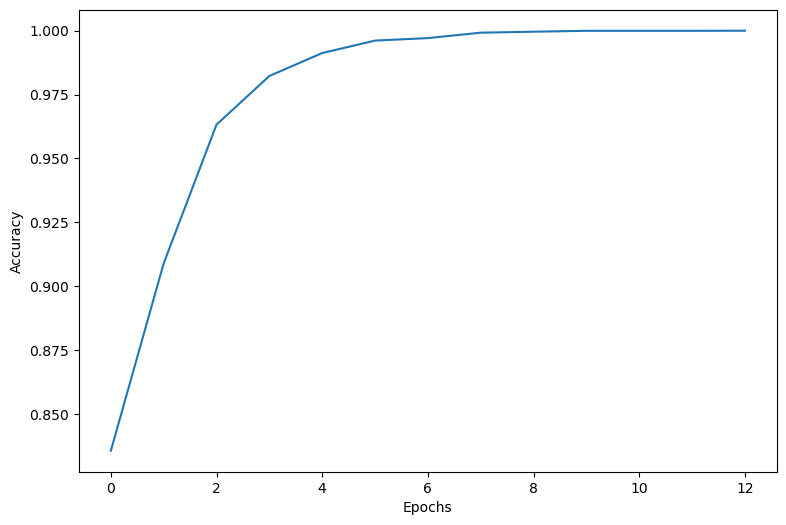

In [29]:
history_json = json.load(open(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", ".json")), "r"))
plt.figure(figsize=(9, 6))
plt.plot(history_json['accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

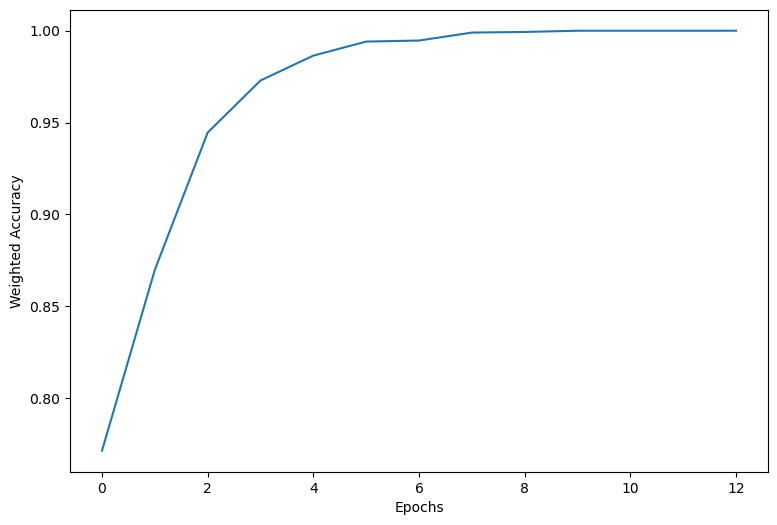

In [30]:
history_json = json.load(open(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", ".json")), "r"))
plt.figure(figsize=(9, 6))
plt.plot(history_json['weighted_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Weighted Accuracy")
plt.show()

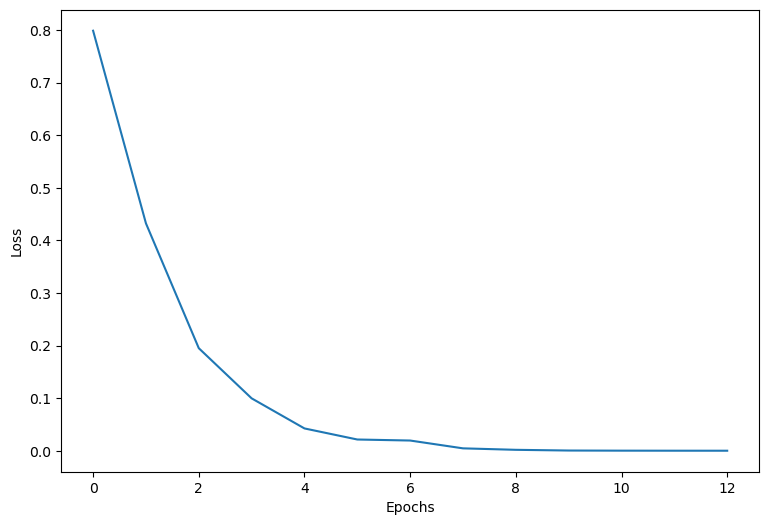

In [31]:
history_json = json.load(open(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", ".json")), "r"))
plt.figure(figsize=(9, 6))
plt.plot(history_json['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [32]:
# model = load_model(os.path.join(MODEL_DIR, MODEL_NAME))
# results_train = model.evaluate(train_dataset, workers=12, use_multiprocessing=True)
# print(f"Train accuracy: {results_train[1]:0.2%}\nTrain weighted accuracy: {results_train[2]:0.2%}\nTrain loss: {results_train[0]}")

In [33]:
# model = load_model(os.path.join(MODEL_DIR, MODEL_NAME))
# results_dev = model.evaluate(dev_dataset, workers=12, use_multiprocessing=True)
# print(f"Dev accuracy: {results_dev[1]:0.2%}\nDev weighted accuracy: {results_dev[2]:0.2%}\nDev loss: {results_dev[0]}")

In [34]:
model = load_model(os.path.join(MODEL_DIR, MODEL_NAME))
results_test = model.evaluate(test_dataset, workers=12, use_multiprocessing=True)
print(f"Test accuracy: {results_test[1]:0.2%}\nTest weighted accuracy: {results_test[2]:0.2%}\nTest loss: {results_test[0]}")

2023-06-23 21:44:49.656823: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


133/133 [==============================] - 56s 330ms/step - loss: 0.0168 - accuracy: 0.9939 - weighted_accuracy: 0.9926
Test accuracy: 99.39%
Test weighted accuracy: 99.26%
Test loss: 0.016821179538965225


In [35]:
test_dataset_slices = list(test_dataset.as_numpy_iterator())
x_true = np.concatenate([batch[0] for batch in test_dataset_slices], axis=0)
y_true = np.concatenate([batch[1] for batch in test_dataset_slices], axis=0)
test_sample_weight = np.concatenate([batch[2] for batch in test_dataset_slices], axis=0)
ohe = joblib.load(os.path.join(MODEL_DIR, MODEL_NAME.replace(".h5", "_ohe.pkl")))

In [36]:
model = load_model(os.path.join(MODEL_DIR, MODEL_NAME))
for i in tqdm(range(0, x_true.shape[0], BATCH_SIZE), desc="Getting predictions for test set"):
    if i == 0:
        y_pred = model.predict(x_true[i:i+BATCH_SIZE], verbose=0)
    else:
        y_pred = np.concatenate((y_pred, model.predict(x_true[i:i+BATCH_SIZE], verbose=0)), axis=0)

Getting predictions for test set: 100%|██████████| 133/133 [00:54<00:00,  2.45it/s]


In [37]:
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_true, axis=1)

In [38]:
print(classification_report(y_true, y_pred, target_names=ohe.categories_[0]))

              precision    recall  f1-score   support

       anger       1.00      0.98      0.99       328
     boredom       0.90      1.00      0.95       109
     disgust       0.99      1.00      0.99       274
        fear       0.99      0.96      0.97       140
    hapiness       0.95      1.00      0.97       171
  irritation       1.00      0.99      1.00      2789
     neutral       1.00      1.00      1.00       106
     sadness       1.00      1.00      1.00       313

    accuracy                           0.99      4230
   macro avg       0.98      0.99      0.99      4230
weighted avg       0.99      0.99      0.99      4230



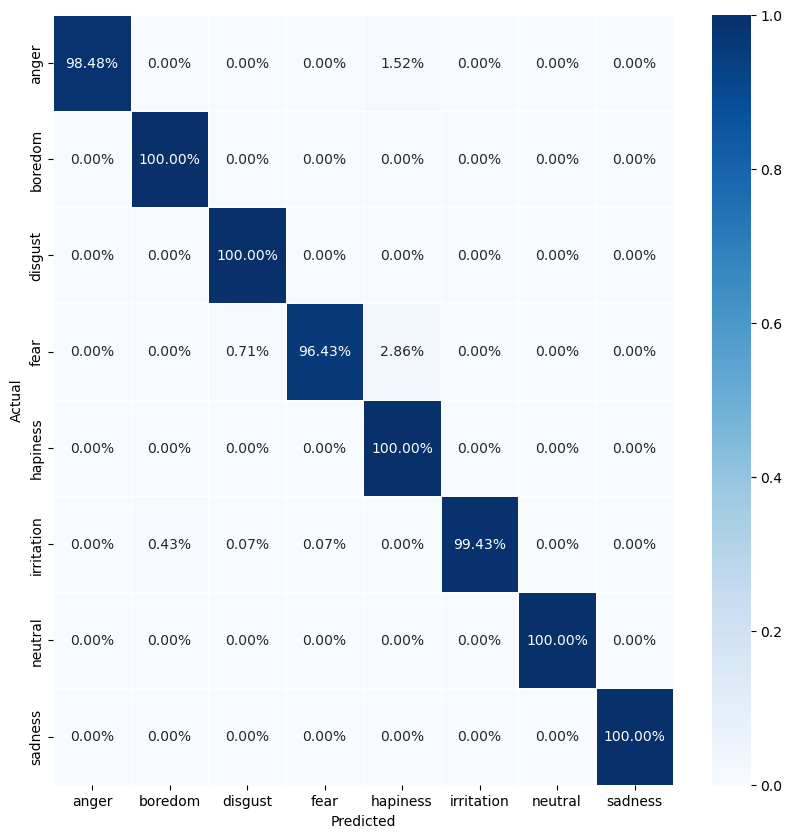

In [39]:
confusion_mat = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, fmt=".2%", xticklabels=ohe.categories_[0], yticklabels=ohe.categories_[0], cmap="Blues", linewidths=0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()